# Add the lasa.py file in same directory as the jupyter notebook

In [1]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\sengu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

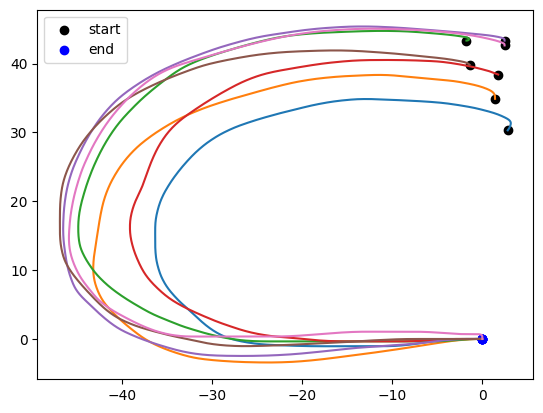

In [14]:
#letter should be one of c,j,s
#data,x,xd = load_data("j")
#data,x,xd = load_data("s")
data,x,xd = load_data("c")

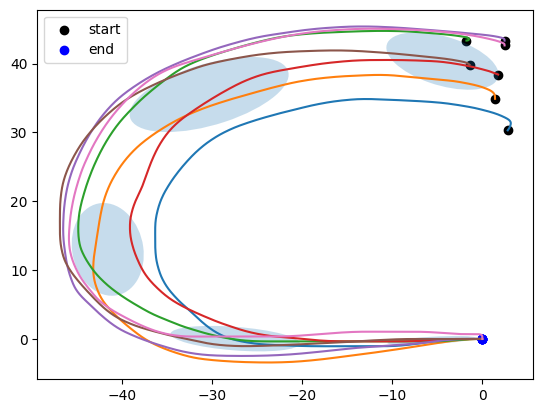

In [ ]:
def init_gaussians(y,n=3):
    '''
    initializes the gaussian based on time fragmentaion

    params:
        y : array of shape (number of trajectories,number of timesteps,2)
    returns:
        mvns: list of gmr.MVN() initialized objects
    '''
    l = y.shape[1]//n
    y_split  = [y[:,i*l:] if i==n-1 else y[:,i*l:(i+1)*l] for i in range(n)]
    mvns = [gmr.MVN().from_samples(x.reshape(-1,2)) for x in y_split]
    splot = plt.subplot(111)
    plot_curves(y)
    for mvn in mvns:
        gmr.plot_error_ellipse(splot,mvn,factors=[1])
    return mvns

mvns = init_gaussians(data,5)

In [23]:
class RBFN:
    def __init__(self,mvns,bias=True):
        '''
            gaussians for weights
        '''
        self.mvns = mvns
        self.bias = bias

    def _compute_features(self, X):
        """
        Compute RBF feature matrix Phi
        Phi shape: (n_points, n_gaussians)
        """
        Phi = []

        for mvn in self.mvns:
            norm_factor, exponent = mvn.to_norm_factor_and_exponents(X)
            probs = norm_factor * np.exp(exponent)
            Phi.append(probs)

        Phi = np.stack(Phi, axis=1)  # (n_points, n_gaussians)
        return Phi
    
    def fit(self,X,Y):
        '''
        store the weight matrix into self.w

        self.w should be array of shape (len(self.mvns)+1,2) if bias is enabled and
        (len(self.mvns),2) if bias is False


        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        '''
        # Compute RBF features
        Phi = self._compute_features(X)

        # Add bias column if required
        if self.bias:
            Phi = np.hstack([Phi, np.ones((Phi.shape[0],1))])

        # Ridge regularization
        lam = 1e-6
        I = np.eye(Phi.shape[1])

        # Closed-form solution
        self.w = np.linalg.inv(Phi.T @ Phi + lam * I) @ Phi.T @ Y


    def predict(self,X):
        '''
        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        '''
        Phi = self._compute_features(X)

        if self.bias:
            Phi = np.hstack([Phi, np.ones((Phi.shape[0],1))])

        return Phi @ self.w


    def ode_differential(self,x,t):
        '''
        function used for rk4 simulation
        '''
        return self.predict(x[None])[0]


    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        '''
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        '''
        # Calculate slopes
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )

            # Calculate new x and y
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        '''
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        '''
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)

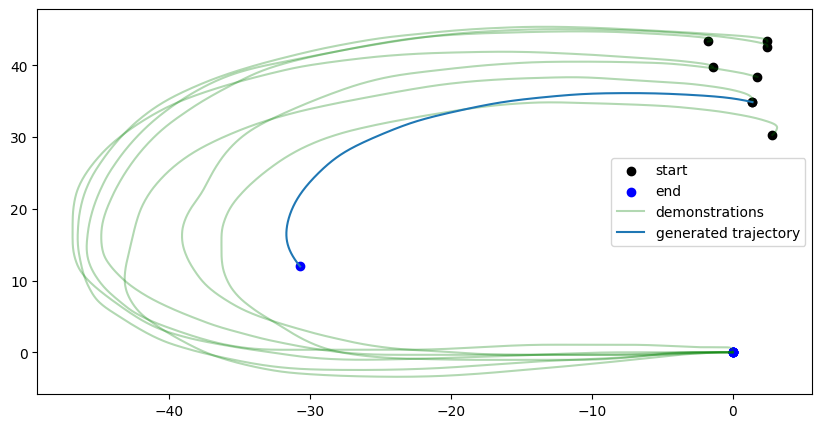

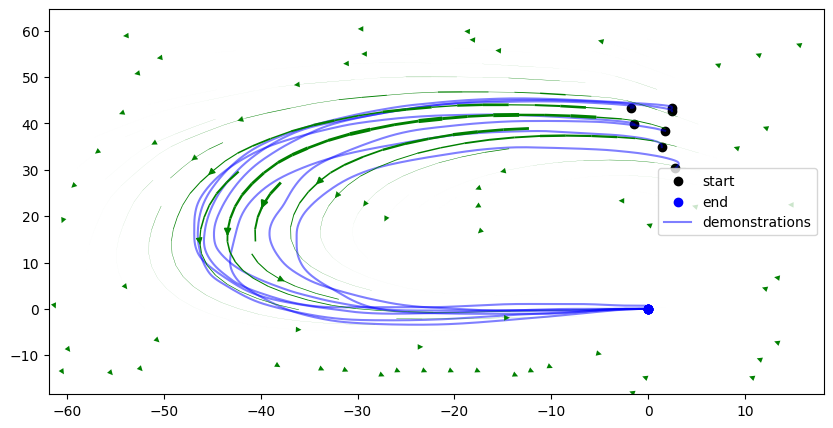

In [ ]:
#fitting the model to data
model = RBFN(mvns,bias=False)
model.fit(x,xd)

#starting point for imitation
x0 = data[0][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=10)

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")

#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")

streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

# Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \
Ans:
No, the learned RBFN dynamical system does not guarantee a Global asymptotic Stable (GAS) point. The model is learned using unconstrained regression:

$$
\dot{x} = \Phi(x) W
$$

There is no Lyapunov stability constraint or negative definiteness enforcement. The system shows local convergence near the demonstrated trajectories, but it is not globally stable for arbitrary initial conditions.

Q2.Try different initial points, and simulate the process.

For initial points close to the demonstrations, the generated trajectories follow the “C” shape and converge near the goal. For initial points far from the training region, trajectories may diverge or move in unrealistic straight-line directions due to weak Gaussian activations.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \
Ans:
With few Gaussians, the model underfits and fails to reproduce the trajectory accurately. With a moderate number of Gaussians, imitation improves significantly. With too many Gaussians, the model may overfit and generalization outside the demonstrated region degrades. Thus, increasing Gaussians improves fitting accuracy but can reduce generalization.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \
Ans:
No, the system does not guarantee Global asymptotic Stability. Although trajectories may converge locally near the demonstrated region, stability is not mathematically enforced. For distant initial conditions, divergence or unrealistic behavior can occur.

Q2.Try different initial points, and simulate the process.

Initial points near the demonstrations produce reasonable imitation trajectories. Far initial points lead to unstable or inaccurate motion due to poor extrapolation of the RBF basis functions.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \
Ans:
Few Gaussians result in underfitting and overly smooth trajectories. A moderate number provides good reconstruction. Too many Gaussians increase variance and may introduce instability outside the training region, reducing generalization.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \
Ans:
No, the RBFN model does not ensure Global asymptotic Stability. The learned system may appear locally stable near the demonstration region, but global convergence is not guaranteed since no stability constraints are imposed during learning.

Q2.Try different initial points, and simulate the process.

For initial conditions close to the demonstrations, trajectories follow the “S” shape reasonably well. For points far from the training manifold, trajectories deviate significantly or become unstable.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \
Ans:
Since the “S” shape is more complex, it requires more Gaussians for accurate fitting. Too few Gaussians fail to capture curvature changes, while too many Gaussians may cause overfitting and poor extrapolation, reducing generalization performance.



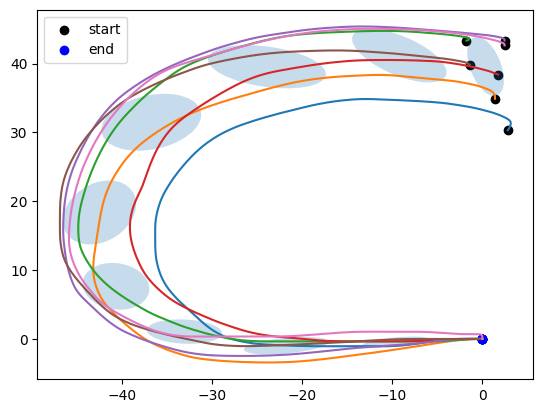

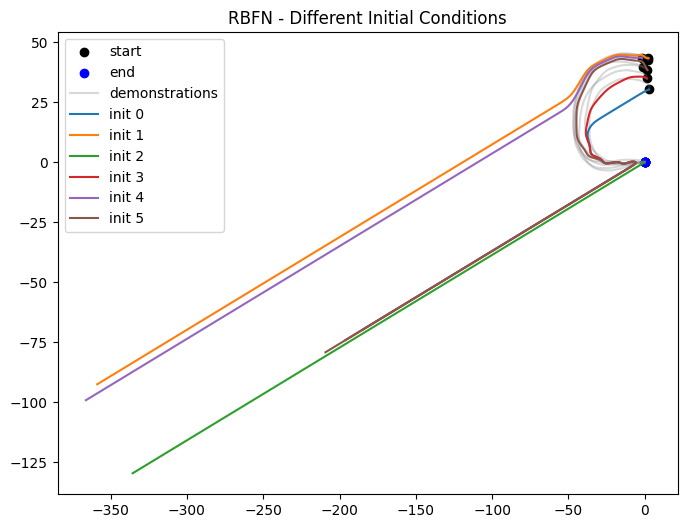

In [26]:
############################
# Try Different Initial Points
############################

# initialize with some gaussians
mvns = init_gaussians(data, 10)
model = RBFN(mvns, bias=True)
model.fit(x, xd)

# Define various starting points
initial_points = [
    data[0][0],                  # demo start
    data[4][0],                  # another demo start
    np.array([0, 0]),            # center
    data[1][0],
    data[2][0],
    data[3][0],
]

plt.figure(figsize=(8,6))
plot_curves(data, alpha=0.3, c="gray", label="demonstrations")

for i, x0 in enumerate(initial_points):
    x_sim, _ = model.imitate(x0, t_end=10)
    plt.plot(x_sim[:,0], x_sim[:,1], label=f"init {i}")

plt.title("RBFN - Different Initial Conditions")
plt.legend()
plt.show()


Number of Gaussians: 2


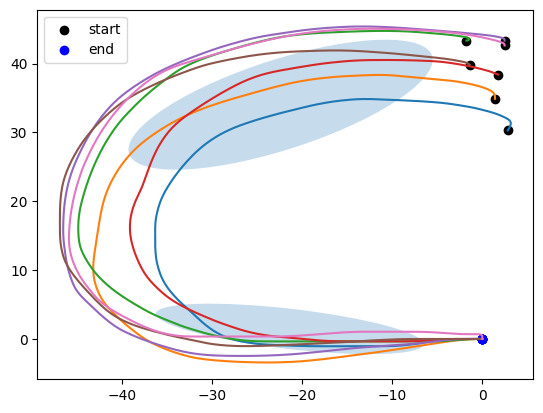

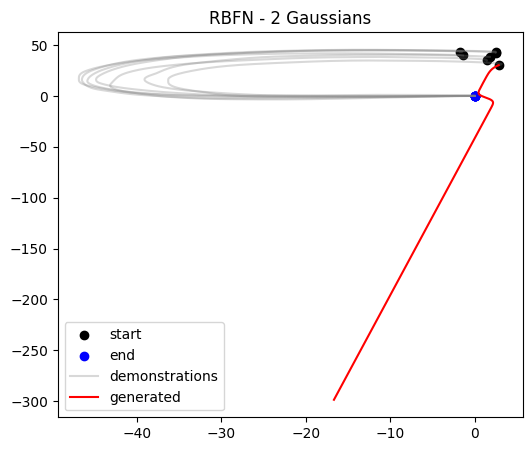


Number of Gaussians: 5


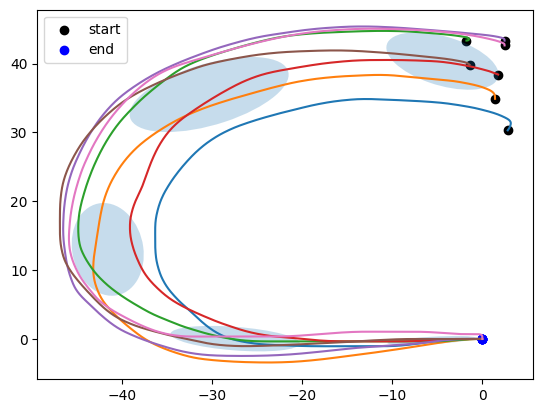

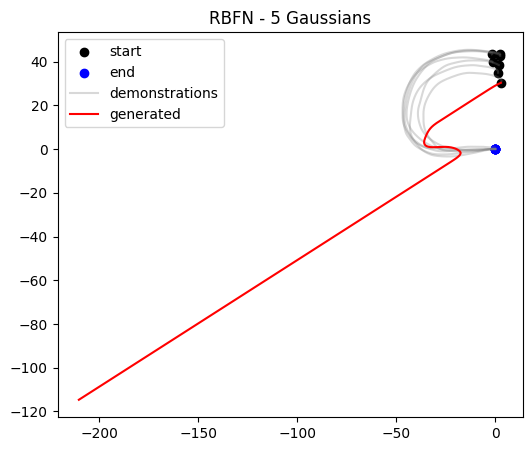


Number of Gaussians: 10


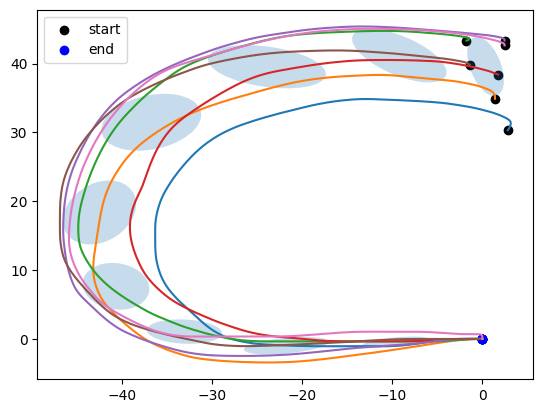

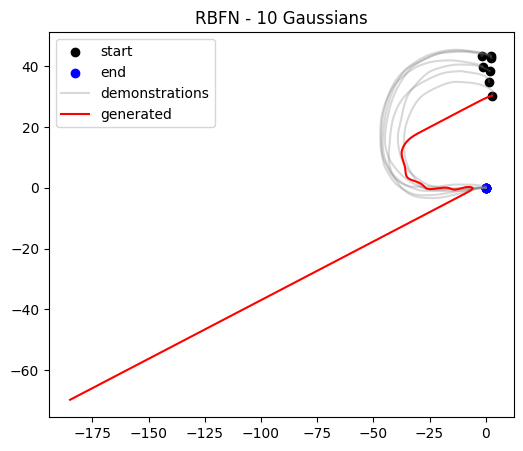


Number of Gaussians: 20


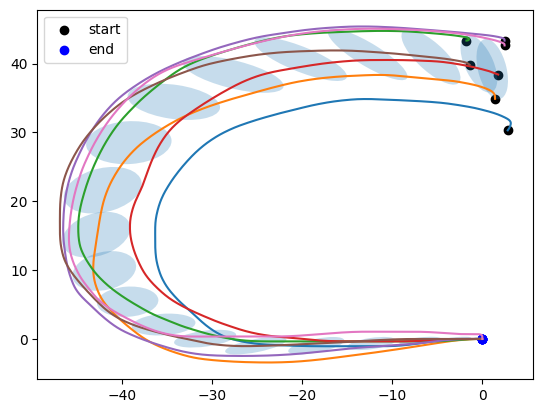

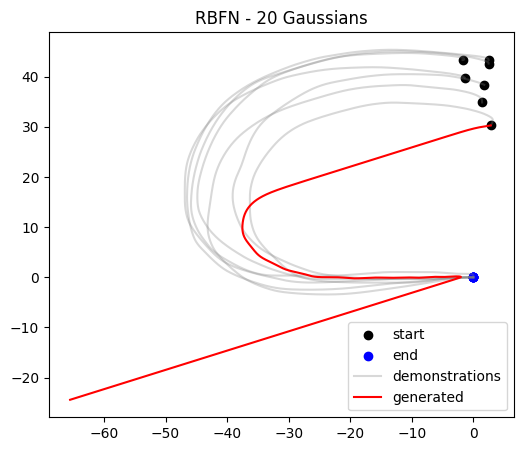

In [20]:
#####################################
# Try Different Numbers of Gaussians
#####################################

gaussian_numbers = [2, 5, 10, 20]

for n in gaussian_numbers:
    
    print(f"\nNumber of Gaussians: {n}")
    
    mvns = init_gaussians(data, n)
    model = RBFN(mvns, bias=True)
    model.fit(x, xd)
    
    x0 = data[0][0]
    x_sim, _ = model.imitate(x0, t_end=10)
    
    plt.figure(figsize=(6,5))
    plot_curves(data, alpha=0.3, c="gray", label="demonstrations")
    plt.plot(x_sim[:,0], x_sim[:,1], c="r", label="generated")
    plt.title(f"RBFN - {n} Gaussians")
    plt.legend()
    plt.show()


# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment4.ipynb**